In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

In [37]:
mnist=fetch_openml('mnist_784',version=1)

In [38]:
X,y=mnist['data'],mnist['target']

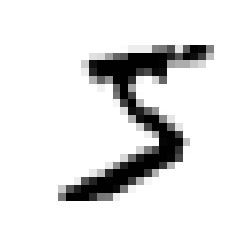

In [39]:
image=X[0].reshape(28,28) 
plt.imshow(image,cmap=mpl.cm.binary,interpolation='nearest')
plt.axis('off')
plt.show()

In [40]:
y=y.astype(np.uint8)

#splitting the datasets

In [41]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [42]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

Here we will train our model using Stocastic Gradient Descent(SGD) classifier to test for 5

In [43]:
sgd=SGDClassifier(random_state=42)
sgd.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
def display_scores(scores):
    print(f"Score:{scores}\nMean Score:{np.multiply(scores.mean(),100)}\nStandard Deviation:{np.multiply(scores.std(),100)}")

In [45]:
some_digit=X[0]
sgd.predict([some_digit])
scores=cross_val_score(sgd, X_train, y_train_5, scoring="accuracy", cv=3)
display_scores(scores)

Score:[0.9532  0.95125 0.9625 ]
Mean Score:95.565
Standard Deviation:0.49086658065099426


In [46]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X, y=None):
        return np.zeros((len(X),1),dtype=bool)

never5=Never5Classifier()
scores=cross_val_score(never5, X_train,y_train_5,scoring="accuracy",cv=3)
display_scores(scores)

Score:[0.91125 0.90855 0.90915]
Mean Score:90.96499999999999
Standard Deviation:0.11575836902790325


In [47]:
y_train_predict=cross_val_predict(sgd, X_train, y_train_5, cv=3)


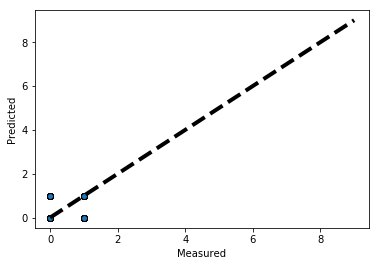

In [48]:
fig, ax= plt.subplots()
ax.scatter(y_train_5,y_train_predict, edgecolors=[0,0,0])
ax.plot([y.min(),y.max()],[y.min(),y.max()],'k--',lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
confusion_mat=confusion_matrix(y_train_5,y_train_predict)
precision=precision_score(y_train_5,y_train_predict)
recall=recall_score(y_train_5,y_train_predict)
f1=f1_score(y_train_5,y_train_predict)
print(np.multiply(precision,100),np.multiply(recall,100), np.multiply(f1,100))

73.25581395348837 80.18815716657444 76.56538969616909


In [50]:
y_scores=sgd.decision_function([some_digit])
threshold=0
y_some_digit_pred=(y_scores<threshold)
y_some_digit_pred

array([ True])

In [51]:
y_scores=cross_val_predict(sgd, X_train, y_train_5, method='decision_function', cv=3)

In [52]:
y_scores

array([ 130454.39322866, -292310.89416081, -851504.62149277, ...,
        361078.59565149, -432547.19353153, -420755.44332381])

In [53]:
def plot_precision_recall_curve(precision, recall, threshold):
    ax, fig=plt.subplots(1,1,figsize=(15,7))
    ax=plt.axes()
    plt.plot(threshold, precision[:-1],'b--',label="Precision")
    plt.plot(threshold, recall[:-1],'g-',label='Recall')
    ax.set_yticks(np.arange(0,1.1,0.1))
    #ax.set_xticks(np.arange(threshold.min(),threshold.max()))
    plt.grid()
    ax.set_xlabel('Threshold')
    plt.legend()

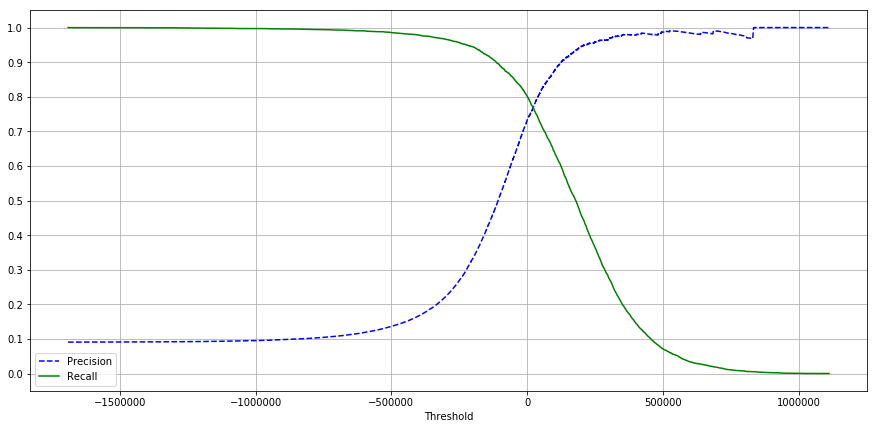

In [54]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold= precision_recall_curve(y_train_5,y_scores)
plot_precision_recall_curve(precision,recall,threshold)
plt.show()

In [55]:
threshold_with_90_precision=threshold[np.argmax(precision>=0.90)]
threshold_with_90_precision

124997.76937872983

In [56]:
y_train_predict_90=(y_scores>threshold_with_90_precision)
print(precision_score(y_train_5, y_train_predict_90),recall_score(y_train_5, y_train_predict_90))

0.9002493765586035 0.5993359158826784


In [57]:
def plot_roc_curve(fpr,tpr,label=None):
    fig, ax=plt.subplots(1,1)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    ax.set_xlabel('False Positive Rate(1-Specificity)')
    ax.set_ylabel('True Positive Rate(Recall/Sensitivity)')
    ax.grid()
    plt.show()

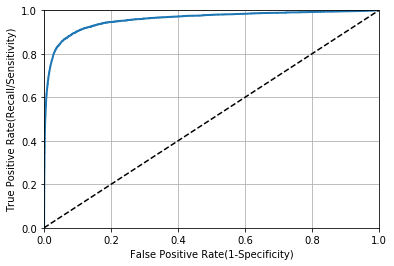

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, threshold= roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr,tpr)

In [59]:
roc_auc_score(y_train_5,y_scores)

0.9584692857783504

In [60]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(random_state=42)
y_forest_predict=cross_val_predict(forest, X_train, y_train_5, cv=3, method='predict_proba')
forest_fpr, forest_tpr, probabilities = roc_curve(y_train_5, y_forest_predict[:,1])

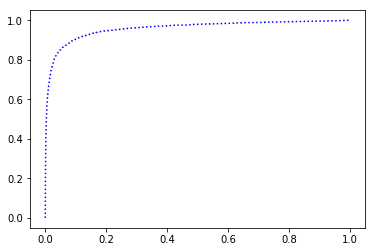

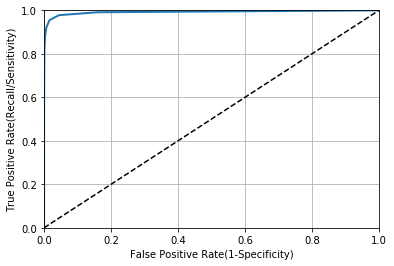

In [61]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(forest_fpr,forest_tpr,"RandomForest")
plt.show()

In [62]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]

In [64]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [65]:
#y_predict=cross_val_predict(knn_clf,X_train,y_multilabel,cv=2)
#y_predict

#Muliclass/Multioutput classification

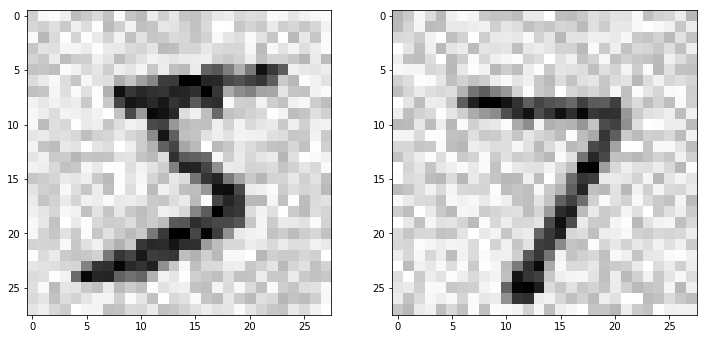

In [66]:
noise=np.random.randint(0,100,(len(X_train),784))
X_train_noise=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_noise=X_test+noise
y_train_n=X_train
y_test_n=X_test

fig,ax=plt.subplots(1,2,figsize=(12,8))
ax[0].imshow(X_train_noise[0].reshape(28,28),cmap=mpl.cm.binary,interpolation='nearest')
ax[1].imshow(X_test_noise[0].reshape(28,28),cmap=mpl.cm.binary,interpolation='nearest')
plt.show()

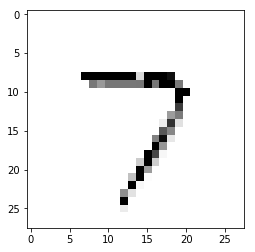

In [67]:
knn_clf.fit(X_train_noise,y_train_n)
clean_digit=knn_clf.predict([X_test[0]])
plt.imshow(clean_digit.reshape(28,28),cmap=mpl.cm.binary,interpolation='nearest')
plt.show()

#Achieving Accuracy of 97% on MNIST dataset using KNN

from sklearn.model_selection import GridSearchCV
param_grid=[{'weights':['uniform','distance'],
             'n_neighbors':[3,4,5]}]
knn1_clf=KNeighborsClassifier()
grid_search=GridSearchCV(knn1_clf,param_grid,cv=3,verbose=3)
grid_search.fit(X_train,y_train)

In [108]:
from scipy.ndimage.interpolation import shift
def shift_image(image_array,shift_index):
    image=image_array.reshape(28,28)
    return shift(image,shift_index,cval=0,mode='constant').reshape([-1])

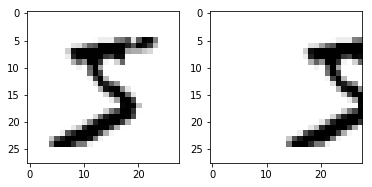

In [83]:
shifted_image=shift_image(X_train[0],[0,10])
fig,ax=plt.subplots(1,2)
ax[0].imshow(X_train[0].reshape(28,28),cmap=mpl.cm.binary,interpolation='nearest')
ax[1].imshow(shifted_image.reshape(28,28),cmap=mpl.cm.binary,interpolation='nearest')
plt.show()

In [104]:
X_train_augmented=[image for image in X_train]
y_train_augmented=[label for label in y_train]

for shift_coordinates in ([0,1],[0,-1],[1,0],[-1,0]):
    for image,label in zip(X_train,y_train):
        X_train_augmented.append(shift_image(image,shift_coordinates))
        y_train_augmented.append(label)
        


In [106]:
type(X_train_augmented)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [98]:
X_train_augmented

array([array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  

In [107]:
new_knn_clf=KNeighborsClassifier(n_neighbors=4)
new_knn_clf.fit(X_train_augmented,y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [ ]:
scores=cross_val_score(new_knn_clf,X_train_augmented,y_train_augmented,scoring='accuracy',cv=3)
scores